Connected to database: ../Data/data.db
Using database at: C:\Users\kemoo\PycharmProjects\Stock_AI_Predictor\Data\data.db
Loaded 12155 news articles for AAPL
Loaded 11006 stock price points
Timedelta = 1 day, 0:00:00 days


C:\Users\kemoo\AppData\Local\Temp\ipykernel_48332\1453117307.py:89: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_stock_returns = daily_stock.pct_change()



Correlation Analysis:
cumulative_return: correlation = 0.0285, p-value = 0.4873
max_return: correlation = 0.0285, p-value = 0.4873
min_return: correlation = 0.0285, p-value = 0.4873
volatility: correlation = nan, p-value = nan

Sample of classified impact:
Date: 2025-04-05
  Sentiment: 0.1256 (neutral)
  Price change: 0.00% (weak, neutral)
  Overall impact: low

Date: 2025-04-06
  Sentiment: 0.1452 (neutral)
  Price change: -4.29% (strong, negative)
  Overall impact: significant

Date: 2025-04-07
  Sentiment: 0.0376 (neutral)
  Price change: -4.52% (strong, negative)
  Overall impact: significant

Date: 2025-04-08
  Sentiment: 0.0924 (neutral)
  Price change: 15.50% (strong, positive)
  Overall impact: significant

Date: 2025-04-09
  Sentiment: 0.1105 (neutral)
  Price change: -3.89% (strong, negative)
  Overall impact: significant


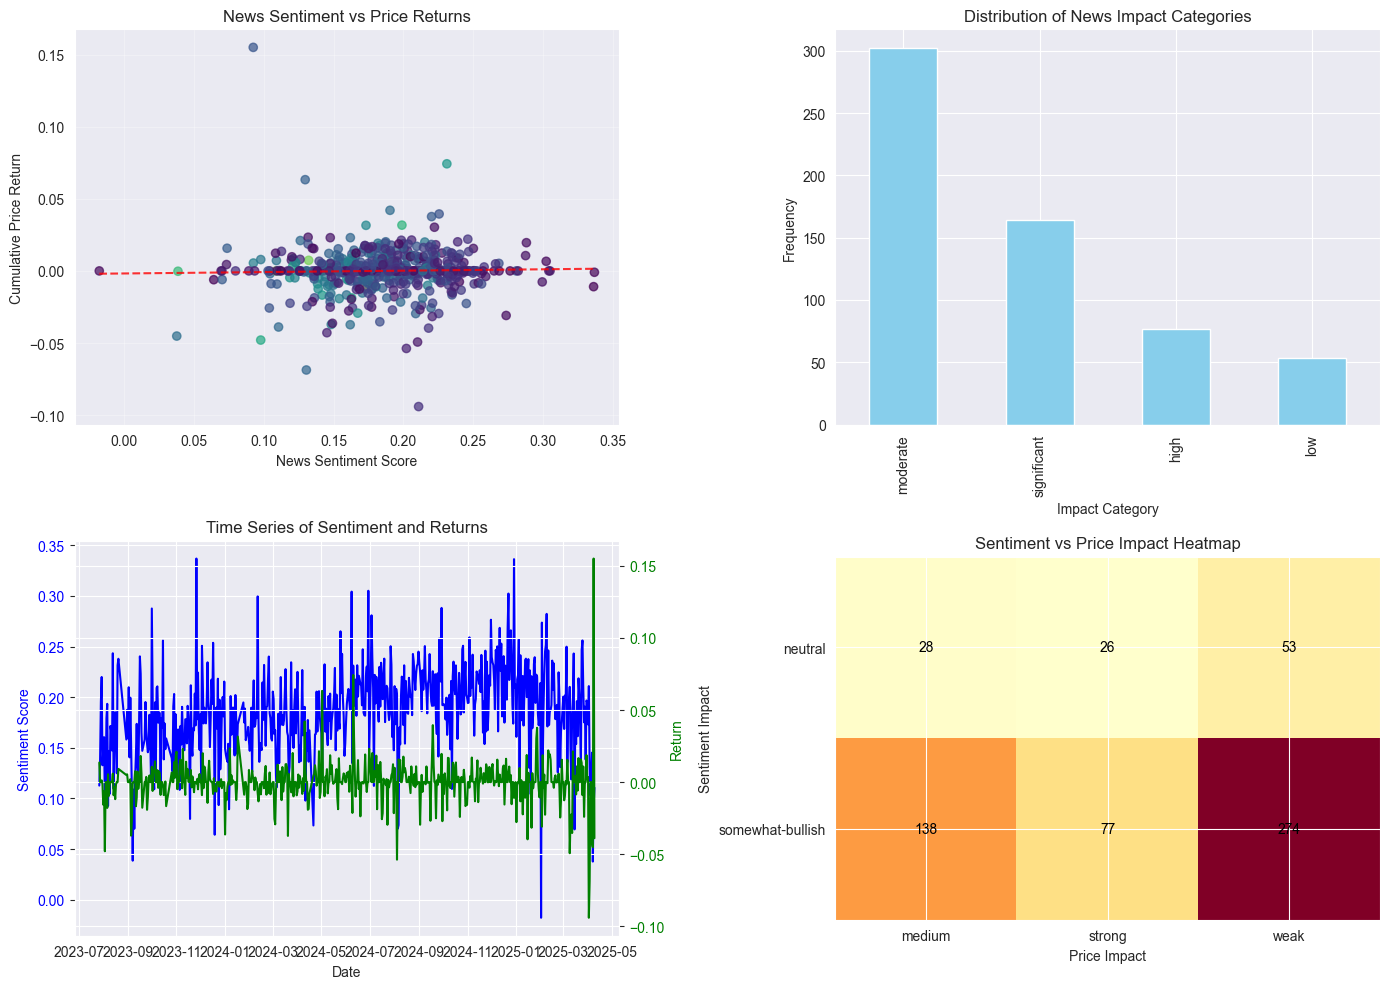

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from datetime import timedelta
from Data.db import Database

class NewsImpactAnalyzer:
    def __init__(self, database):
        self.db = database
        self.news_data = None
        self.stock_data = None
    
    def load_data(self, stock_id, timeframe=60, days_window=3):
        """
        Load news and stock data
        
        Parameters:
        - stock_id: ID of the stock to analyze
        - timeframe: Timeframe for stock data in minutes
        - days_window: Number of days to look ahead for stock price impact
        """
        # Load news data
        self.news_data = self.db.get_live_news_articles()
        
        # Filter news data for relevant ticker
        stock_symbol = self._get_stock_symbol(stock_id)
        self.news_data = self._filter_news_for_ticker(self.news_data, stock_symbol)
        
        # Load stock data
        self.stock_data = self.db.get_stock_data(stock_id, timeframe)
        
        # Ensure both datasets have data
        if self.news_data.empty or self.stock_data.empty:
            raise ValueError("Either news data or stock data is empty")
            
        print(f"Loaded {len(self.news_data)} news articles for {stock_symbol}")
        print(f"Loaded {len(self.stock_data)} stock price points")
        
        return self.news_data, self.stock_data
    
    def _get_stock_symbol(self, stock_id):
        """Get stock symbol from stock ID using a sample query"""
        sample = self.db.get_stock_data(stock_id, 60)
        if 'StockSymbol' in sample.columns:
            return sample['StockSymbol'].iloc[0]
        else:
            return f"Stock_{stock_id}"  # Fallback
    
    def _filter_news_for_ticker(self, news_df, ticker):
        """Filter news data to only include articles mentioning the ticker"""
        # Check if there's a Ticker_Sentiment column with ticker info
        if 'Ticker_Sentiment' in news_df.columns:
            # This assumes Ticker_Sentiment has information about which tickers are mentioned
            # Adapt this logic based on actual structure of Ticker_Sentiment
            filtered_news = news_df[news_df['Ticker_Sentiment'].str.contains(ticker, na=False)]
            if not filtered_news.empty:
                return filtered_news
        
        # If no specific ticker filtering is possible, return all news
        return news_df
    
    def align_news_with_price_movements(self, impact_window=timedelta(days=2), min_articles=1):
        """
        Align news articles with subsequent stock price movements
        
        Parameters:
        - impact_window: Time window to look for price impact after news
        - min_articles: Minimum number of articles to consider a day newsworthy
        
        Returns:
        - DataFrame with news sentiment and subsequent price movements
        """
        # Ensure data is loaded
        if self.news_data is None or self.stock_data is None:
            raise ValueError("Data not loaded. Call load_data() first.")
        
        # Group news by date and calculate average sentiment
        daily_news = self.news_data.groupby(self.news_data['Date'].dt.date).agg({
            'Overall_Sentiment_Score': 'mean', 
            'ID': 'count'  # Count articles per day
        }).rename(columns={'ID': 'article_count'})
        
        # Filter days with minimum article count
        daily_news = daily_news[daily_news['article_count'] >= min_articles]
        
        # Calculate daily stock returns
        daily_stock = self.stock_data['ClosePrice'].resample('D').last()
        daily_stock_returns = daily_stock.pct_change()
        
        # Initialize result dataframe
        result = []
        
        # For each news day, find subsequent price movements
        for news_date, news_row in daily_news.iterrows():
            news_date = pd.Timestamp(news_date)
            
            # Define the impact window
            start_date = news_date
            end_date = news_date + impact_window
            
            # Find stock returns in the impact window
            future_returns = daily_stock_returns[(daily_stock_returns.index > start_date) & 
                                                (daily_stock_returns.index <= end_date)]
            
            if not future_returns.empty:
                # Calculate cumulative return in the impact window
                cumulative_return = (1 + future_returns).prod() - 1
                max_return = future_returns.max()
                min_return = future_returns.min()
                volatility = future_returns.std()
                
                result.append({
                    'news_date': news_date,
                    'sentiment_score': news_row['Overall_Sentiment_Score'],
                    'article_count': news_row['article_count'],
                    'cumulative_return': cumulative_return,
                    'max_return': max_return,
                    'min_return': min_return,
                    'volatility': volatility
                })
        
        return pd.DataFrame(result)
    
    def analyze_sentiment_price_correlation(self, aligned_data):
        """
        Analyze correlation between news sentiment and price movements
        
        Parameters:
        - aligned_data: DataFrame from align_news_with_price_movements()
        
        Returns:
        - Dictionary with correlation coefficients and p-values
        """
        correlations = {}
        
        # Calculate correlations for different metrics
        for metric in ['cumulative_return', 'max_return', 'min_return', 'volatility']:
            if len(aligned_data) > 2:  # Need at least 3 points for correlation
                corr, p_value = pearsonr(aligned_data['sentiment_score'], aligned_data[metric])
                correlations[metric] = {'correlation': corr, 'p_value': p_value}
            else:
                correlations[metric] = {'correlation': None, 'p_value': None}
        
        return correlations
    
    def classify_impact(self, aligned_data, sentiment_thresholds=None, return_thresholds=None):
        """
        Classify news impact based on sentiment and price movement thresholds
        
        Parameters:
        - aligned_data: DataFrame from align_news_with_price_movements()
        - sentiment_thresholds: Not used, kept for compatibility
        - return_thresholds: Tuple of (weak/medium, medium/strong) thresholds for returns
        
        Returns:
        - DataFrame with impact classifications
        """
        # Set default thresholds if not provided
        if return_thresholds is None:
            # Calculate based on quantiles if we have enough data
            if len(aligned_data) >= 5:
                return_thresholds = (
                    aligned_data['cumulative_return'].quantile(0.33),
                    aligned_data['cumulative_return'].quantile(0.67)
                )
                print(f"Calculated return thresholds: {return_thresholds}")
            else:
                return_thresholds = (0.005, 0.015)  # Default values - 0.5% and 1.5%
                print("Using default return thresholds: ", return_thresholds)
                
        # Create a copy of the data
        impact_data = aligned_data.copy()
        
        # Classify sentiment using AlphaVantage ranges
        impact_data['sentiment_impact'] = 'neutral'
        impact_data.loc[impact_data['sentiment_score'] <= -0.35, 'sentiment_impact'] = 'bearish'
        impact_data.loc[(impact_data['sentiment_score'] > -0.35) & (impact_data['sentiment_score'] <= -0.15), 'sentiment_impact'] = 'somewhat-bearish'
        impact_data.loc[(impact_data['sentiment_score'] >= 0.15) & (impact_data['sentiment_score'] < 0.35), 'sentiment_impact'] = 'somewhat-bullish'
        impact_data.loc[impact_data['sentiment_score'] >= 0.35, 'sentiment_impact'] = 'bullish'
        
        # Map AlphaVantage sentiment categories to original three-level categories for compatibility
        # This ensures the rest of the code works with the new sentiment classifications
        sentiment_mapping = {
            'bearish': 'weak',
            'somewhat-bearish': 'weak',
            'neutral': 'medium',
            'somewhat-bullish': 'strong',
            'bullish': 'strong'
        }
        
        # Create a temporary column with mapped values for compatibility with existing logic
        impact_data['sentiment_impact_mapped'] = impact_data['sentiment_impact'].map(sentiment_mapping)
        
        # Classify returns (absolute value to capture both positive and negative moves)
        impact_data['price_impact'] = 'medium'
        impact_data.loc[abs(impact_data['cumulative_return']) <= return_thresholds[0], 'price_impact'] = 'weak'
        impact_data.loc[abs(impact_data['cumulative_return']) >= return_thresholds[1], 'price_impact'] = 'strong'
        
        # Classify direction
        impact_data['price_direction'] = 'neutral'
        impact_data.loc[impact_data['cumulative_return'] > 0, 'price_direction'] = 'positive'
        impact_data.loc[impact_data['cumulative_return'] < 0, 'price_direction'] = 'negative'
        
        # Overall impact (combine sentiment strength and price impact)
        # Use the mapped sentiment values for compatibility with existing impact logic
        impact_data['overall_impact'] = 'negligible'
        
        # Define a mapping for impact levels (using mapped sentiment values)
        impact_mapping = {
            ('weak', 'weak'): 'negligible',
            ('weak', 'medium'): 'low',
            ('weak', 'strong'): 'moderate',
            ('medium', 'weak'): 'low',
            ('medium', 'medium'): 'moderate',
            ('medium', 'strong'): 'significant',
            ('strong', 'weak'): 'moderate',
            ('strong', 'medium'): 'significant',
            ('strong', 'strong'): 'high'
        }
        
        # Apply the mapping using the mapped sentiment values
        for sentiment, price in impact_mapping.keys():
            mask = (impact_data['sentiment_impact_mapped'] == sentiment) & (impact_data['price_impact'] == price)
            impact_data.loc[mask, 'overall_impact'] = impact_mapping[(sentiment, price)]
        
        # Drop the temporary mapping column as it's no longer needed
        impact_data.drop('sentiment_impact_mapped', axis=1, inplace=True)
        
        return impact_data
    
    def visualize_impact(self, impact_data, start_date=None, end_date=None):
        """
        Create visualizations for news sentiment impact on stock prices
        
        Parameters:
        - impact_data: DataFrame from classify_impact()
        
        Returns:
        - Matplotlib figure
        """
        if len(impact_data) < 3:
            print("Not enough data points for meaningful visualization")
            return None
        # start_date = "2025-04-10"
        # end_date = "2024-04-10"
        # Filter data based on date range if provided
        if start_date and end_date:
            impact_data = impact_data[(impact_data['news_date'] >= start_date) & 
                                    (impact_data['news_date'] <= end_date)]
        else:
            impact_data = impact_data
        fig, axs = plt.subplots(2, 2, figsize=(14, 10))
        
        # Scatter plot of sentiment vs returns
        axs[0, 0].scatter(impact_data['sentiment_score'], impact_data['cumulative_return'], 
                         alpha=0.7, c=impact_data['article_count'], cmap='viridis')
        axs[0, 0].set_xlabel('News Sentiment Score')
        axs[0, 0].set_ylabel('Cumulative Price Return')
        axs[0, 0].set_title('News Sentiment vs Price Returns')
        axs[0, 0].grid(True, alpha=0.3)
        
        # Add trend line
        if len(impact_data) > 1:
            z = np.polyfit(impact_data['sentiment_score'], impact_data['cumulative_return'], 1)
            p = np.poly1d(z)
            x_trend = np.linspace(impact_data['sentiment_score'].min(), impact_data['sentiment_score'].max(), 100)
            axs[0, 0].plot(x_trend, p(x_trend), "r--", alpha=0.8)
        
        # Bar chart of overall impact distribution
        impact_counts = impact_data['overall_impact'].value_counts()
        impact_counts.plot(kind='bar', ax=axs[0, 1], color='skyblue')
        axs[0, 1].set_xlabel('Impact Category')
        axs[0, 1].set_ylabel('Frequency')
        axs[0, 1].set_title('Distribution of News Impact Categories')
        
        # Time series of sentiment and returns
        ax1 = axs[1, 0]
        ax2 = ax1.twinx()
        
        # Sort by date for time series
        time_data = impact_data.sort_values('news_date')
        
        ax1.plot(time_data['news_date'], time_data['sentiment_score'], 'b-', label='Sentiment')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Sentiment Score', color='b')
        ax1.tick_params(axis='y', labelcolor='b')
        
        ax2.plot(time_data['news_date'], time_data['cumulative_return'], 'g-', label='Return')
        ax2.set_ylabel('Return', color='g')
        ax2.tick_params(axis='y', labelcolor='g')
        
        axs[1, 0].set_title('Time Series of Sentiment and Returns')
        
        # Heatmap of sentiment impact vs price impact
        impact_matrix = pd.crosstab(impact_data['sentiment_impact'], impact_data['price_impact'])
        axs[1, 1].imshow(impact_matrix, cmap='YlOrRd')
        
        # Add text annotations to the heatmap
        for i in range(len(impact_matrix.index)):
            for j in range(len(impact_matrix.columns)):
                axs[1, 1].text(j, i, f"{impact_matrix.iloc[i, j]}", 
                              ha="center", va="center", color="black")
        
        axs[1, 1].set_xticks(range(len(impact_matrix.columns)))
        axs[1, 1].set_yticks(range(len(impact_matrix.index)))
        axs[1, 1].set_xticklabels(impact_matrix.columns)
        axs[1, 1].set_yticklabels(impact_matrix.index)
        axs[1, 1].set_xlabel('Price Impact')
        axs[1, 1].set_ylabel('Sentiment Impact')
        axs[1, 1].set_title('Sentiment vs Price Impact Heatmap')
        
        plt.tight_layout()
        return fig
    
    def run_full_analysis(self, stock_id, timeframe=60, impact_window_days=2, 
                          sentiment_thresholds=None, return_thresholds=None):
        """
        Run the complete news impact analysis pipeline
        
        Parameters:
        - stock_id: ID of the stock to analyze
        - timeframe: Timeframe for stock data in minutes
        - impact_window_days: Number of days to look ahead for stock price impact
        - sentiment_thresholds: Tuple of (weak/medium, medium/strong) thresholds for sentiment
        - return_thresholds: Tuple of (weak/medium, medium/strong) thresholds for returns
        
        Returns:
        - Dictionary with analysis results
        """
        # Load data
        self.load_data(stock_id, timeframe)
        
        print(f"Timedelta = {timedelta(days=impact_window_days)} days")
        # Align news with price movements
        aligned_data = self.align_news_with_price_movements(
            impact_window=timedelta(days=impact_window_days)
        )
        
        if len(aligned_data) < 3:
            print(f"Warning: Only {len(aligned_data)} data points available for analysis.")
            if len(aligned_data) == 0:
                return {
                    "error": "No aligned data points found",
                    "stock_id": stock_id,
                    "aligned_data": aligned_data
                }
        
        # Analyze correlation
        correlations = self.analyze_sentiment_price_correlation(aligned_data)
        
        # Classify impact
        impact_data = self.classify_impact(
            aligned_data, 
            sentiment_thresholds=sentiment_thresholds,
            return_thresholds=return_thresholds
        )
        
        # Visualize (optional)
        fig = self.visualize_impact(impact_data) if len(impact_data) >= 3 else None
        
        # Return results
        return {
            "aligned_data": aligned_data,
            "correlations": correlations,
            "impact_data": impact_data,
            "visualization": fig,
            "sentiment_thresholds": sentiment_thresholds,
            "return_thresholds": return_thresholds
        }


# Example usage
def run_news_impact_analysis():
    from Data.db import Database
    db = Database()
    
    analyzer = NewsImpactAnalyzer(db)
    
    # Run analysis for AAPL (assuming stock_id = 3)
    results = analyzer.run_full_analysis(
        stock_id=3,               # AAPL
        timeframe=60,             # 1-hour data
        impact_window_days=1,     # Look 1 day ahead for price impact
        # sentiment_thresholds=(0.2, 0.6),  # Custom sentiment thresholds
        sentiment_thresholds=(-0.15, 0.15, 0.35), # AlphaVantage's sentiment thresholds
        return_thresholds=(0.005, 0.015)  # 0.5% and 1.5% return thresholds
    )
    
    # Display correlation results
    if 'correlations' in results:
        print("\nCorrelation Analysis:")
        for metric, values in results['correlations'].items():
            # Handle the case where correlation or p-value might be None
            corr = values.get('correlation')
            p_val = values.get('p_value')
            
            if corr is not None and p_val is not None:
                print(f"{metric}: correlation = {corr:.4f}, p-value = {p_val:.4f}")
            else:
                print(f"{metric}: correlation = {corr}, p-value = {p_val} (insufficient data)")
    
    # Display example of classified impact
    if 'impact_data' in results and not results['impact_data'].empty:
        print("\nSample of classified impact:")
        sample = results['impact_data'].tail(5)
        for _, row in sample.iterrows():
            print(f"Date: {row['news_date'].strftime('%Y-%m-%d')}")
            print(f"  Sentiment: {row['sentiment_score']:.4f} ({row['sentiment_impact']})")
            print(f"  Price change: {row['cumulative_return']*100:.2f}% ({row['price_impact']}, {row['price_direction']})")
            print(f"  Overall impact: {row['overall_impact']}")
            print()
    
    # Show the visualization if available
    if 'visualization' in results and results['visualization'] is not None:
        plt.show()
    
    return results


if __name__ == "__main__":
    results = run_news_impact_analysis()